In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,auc,roc_auc_score
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
import warnings
warnings.filterwarnings("ignore")

In [14]:
churn = pd.read_csv('churn.csv')
churn.head()

,Male,Germany,Spain,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,0,1,608,41,1,83807.86,1,0,1,112542.58,0
1,0,0,0,502,42,8,159660.80,3,1,0,113931.57,1
2,0,0,1,850,43,2,125510.82,1,1,1,79084.10,0
3,1,0,1,645,44,8,113755.78,2,1,0,149756.71,1
4,0,1,0,376,29,4,115046.74,4,1,0,119346.88,1


In [15]:
print('There are {} rows and {} columns in the dataset'.format(churn.shape[0], churn.shape[1]))

There are 6383 rows and 12 columns in the dataset


In [16]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6383 entries, 0 to 6382
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Male             6383 non-null   int64  
 1   Germany          6383 non-null   int64  
 2   Spain            6383 non-null   int64  
 3   CreditScore      6383 non-null   int64  
 4   Age              6383 non-null   int64  
 5   Tenure           6383 non-null   int64  
 6   Balance          6383 non-null   float64
 7   NumOfProducts    6383 non-null   int64  
 8   HasCrCard        6383 non-null   int64  
 9   IsActiveMember   6383 non-null   int64  
 10  EstimatedSalary  6383 non-null   float64
 11  Exited           6383 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 598.5 KB


There are no null values.

In [17]:
# Check unique values in each feature
for features in churn.columns:
    print(churn[features].value_counts())
    print('-' * 100)

1    3494
0    2889
Name: Male, dtype: int64
----------------------------------------------------------------------------------------------------
0    3874
1    2509
Name: Germany, dtype: int64
----------------------------------------------------------------------------------------------------
0    5105
1    1278
Name: Spain, dtype: int64
----------------------------------------------------------------------------------------------------
850    155
684     40
705     39
678     37
660     36
      ... 
441      1
433      1
413      1
405      1
376      1
Name: CreditScore, Length: 450, dtype: int64
----------------------------------------------------------------------------------------------------
37    310
38    302
35    302
36    280
33    280
     ... 
84      2
92      2
79      2
83      1
81      1
Name: Age, Length: 66, dtype: int64
----------------------------------------------------------------------------------------------------
1     686
2     666
8     662
3     657
7   

CreditScore, Age, Balance, EstimatedSalary, NumofProducts are numeric features and the rest are categorical features. Target feature Exited is imbalanced which would need to be balanced at the time of modelling.

In [18]:
(churn['Exited'].value_counts(normalize = True) * 100).round()

0    76.0
1    24.0
Name: Exited, dtype: float64

24 percent customers have churned.

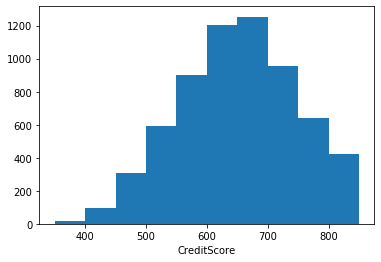

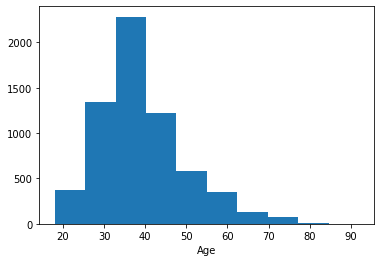

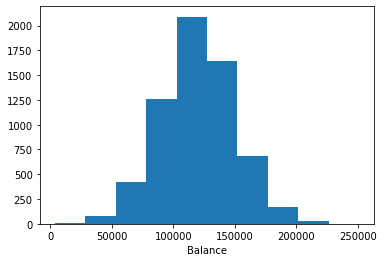

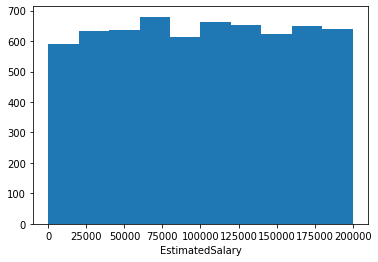

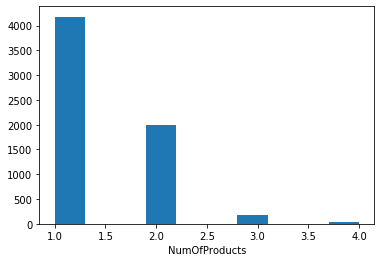

In [19]:
feats = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'NumOfProducts']
for features in feats:
    plt.hist(churn[features])
    plt.xlabel(features)
    plt.show()

Observations

- CreditScore and Age are skewed.
- Distribution of Balance is approximately normal.
- There are almost equal no. of people in a range of salaries.
- Most of the customers have 1 as number of products

In [20]:
# Normalize Age and CreditScore
churn['Age'] = np.log1p(churn['Age'])
churn['CreditScore'] = np.log1p(churn['CreditScore'])

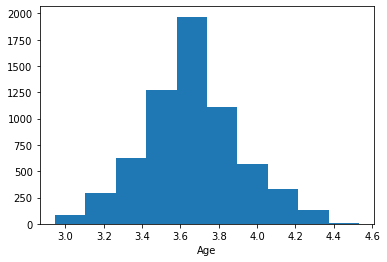

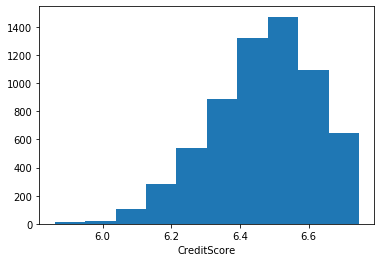

In [21]:
fts = ['Age', 'CreditScore']
for i in fts:
    plt.hist(churn[i])
    plt.xlabel(i)
    plt.show()

In [22]:
print('CreditScore', churn['CreditScore'].skew())
print('Age', churn['Age'].skew())

CreditScore -0.46215675663931394
Age 0.1599655498788113


For both CreditScore and Age skewness is between - 0.5 and 0.5, so the data is now symmetric.

In [23]:
X = churn.drop('Exited', axis = 1)
y = churn['Exited']

In [49]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_sm, y_sm = sm.fit_resample(X, y)

In [50]:
print(X_sm.shape)
print(y_sm.shape)

(9692, 11)
(9692,)


In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size = 0.20, random_state = 10)

In [52]:
from sklearn.preprocessing import MinMaxScaler
def mod_eval(model):
    for mod in model:
        model_pipeline = make_pipeline(MinMaxScaler(), mod)
        scores = cross_validate(model_pipeline,X_train,y_train,cv=5,
                scoring= 'roc_auc')
        print(mod, scores['test_score'].mean())
        print('-' * 100)

In [53]:
models = [LogisticRegression(), GaussianNB(), KNeighborsClassifier(), SVC(), RandomForestClassifier(),
         AdaBoostClassifier(), XGBClassifier()]
mod_eval(models)

LogisticRegression() 0.8431037869597212
----------------------------------------------------------------------------------------------------
GaussianNB() 0.8374467696542162
----------------------------------------------------------------------------------------------------
KNeighborsClassifier() 0.8381846319325419
----------------------------------------------------------------------------------------------------
SVC() 0.8685657008094714
----------------------------------------------------------------------------------------------------
RandomForestClassifier() 0.9128247749596115
----------------------------------------------------------------------------------------------------
AdaBoostClassifier() 0.8852035852590181
----------------------------------------------------------------------------------------------------
[17:56:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with th

XGBClassifier is the best performing model here with highest roc_auc score. 

[20:25:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Top five features:  Index(['Spain', 'NumOfProducts', 'Age', 'Male', 'IsActiveMember'], dtype='object')


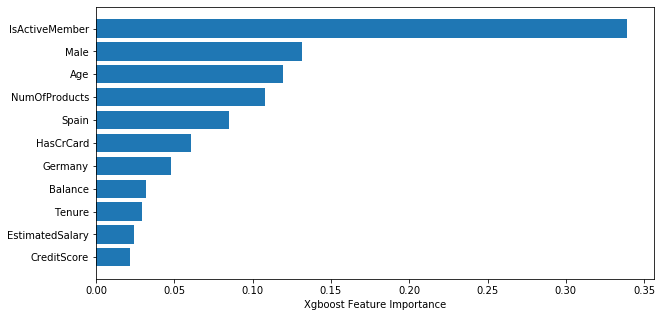

In [63]:
# Get the top 5 features using random forest feature importance
plt.figure(figsize=(10,5))
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
sorted_idx = xgb.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], xgb.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
print('Top five features: ',X_train.columns[sorted_idx][-5:])

In [64]:
# Let's build model on top 5 features and see if there is any improvement
X_train_new = X_train[['Spain', 'NumOfProducts', 'Age', 'Male', 'IsActiveMember']]
model1 = [XGBClassifier()]
mod_eval(model1)

[20:41:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:41:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:41:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:41:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

There is no improvement in roc_auc score.

In [66]:
# Testing predictions on test data
xgc = XGBClassifier(eval_metric = 'logloss')
xgc.fit(X_train, y_train)
y_pred = xgc.predict(X_test)

In [68]:
print('test-set confusion matrix:\n', confusion_matrix(y_test,y_pred)) 
print("recall score: ", recall_score(y_test,y_pred))
print("precision score: ", precision_score(y_test,y_pred))
print("f1 score: ", f1_score(y_test,y_pred))
print("accuracy score: ", accuracy_score(y_test,y_pred))
print("ROC AUC: {}".format(roc_auc_score(y_test, y_pred)))

test-set confusion matrix:
 [[883 106]
 [170 780]]
recall score:  0.8210526315789474
precision score:  0.8803611738148984
f1 score:  0.849673202614379
accuracy score:  0.8576585869004641
ROC AUC: 0.8569368314618699
